In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
!pip install "gym[atari, accept-rom-license]"
!nvidia-smi
# the skeleton of the below code is obtained from the project: https://github.com/bhctsntrk/OpenAIPong-DQN/blob/master/README.md #

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 21.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=664609380f0be1ac8855136c1414759803587bf814e23f817d2d521dd2ec0e95
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
Thu Feb 29 13:31:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Pe

In [2]:
import gym
import cv2

import time
import json
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
import matplotlib.pyplot as plt

In [3]:
ENVIRONMENT = "PongDeterministic-v4"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "./pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = True  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = False  # Load model from file
LOAD_FILE_EPISODE = 0  # Load Xth episode from file

BATCH_SIZE = 32  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 501 # Max episode
MAX_STEP = 100000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 40000  # Min memory len before start train

GAMMA = 0.99  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 0.995  # Epsilon decay rate by step

RENDER_GAME_WINDOW = False  # Opens a new window to render the game (Won't work on colab default)

# Plotting data
episode_rewards = []
episode_steps = []
paddle_hits = []
serving_times = []
episode_durations = []
mean_last_100_ep_reward = []
mean_last_100_ep_steps = []
mean_last_100_paddle_hits = []
mean_last_100_ep_durations =[]
mean_last_100_serving_times =[]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class DuelCNN(nn.Module):
    """
    CNN with Duel Algo. https://arxiv.org/abs/1511.06581
    """
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node

    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        """
        Calcs conv layers output image sizes
        """
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q

In [5]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (210, 160, 3). Used as input size in network
        self.state_size_h = environment.observation_space.shape[0]
        self.state_size_w = environment.observation_space.shape[1]
        self.state_size_c = environment.observation_space.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = environment.action_space.n

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque holds replay mem.
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    def preProcess(self, image):
        """
        Process image crop resize, grayscale and normalize the images
        """
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    def act(self, state):
        """
        Get state and do action
        Two option can be selectedd if explore select random action
        if exploit ask nnet for action
        """

        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action

    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # We get out minibatch and turn it to numpy array
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    def storeResults(self, state, action, reward, nextState, done):
        """
        Store every result to memory
        """
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

In [6]:
environment = gym.make(ENVIRONMENT)  # Get env
agent = Agent(environment)  # Create Agent



if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
last_100_ep_steps = deque(maxlen=100)  # Last 100 episode steps
last_100_paddle_hits = deque(maxlen=100)  # Last 100 paddle hits
last_100_ep_durations = deque(maxlen=100)  # Last 100 episode durations
last_100_serving_times = deque(maxlen=100)  # Last 100 serving times
total_step = 1  # Cumulkative sum of all steps in episodes

for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # Keep time
    serving_start_time = None  # Initialize serving start time
    paddle_hit_count = 0  # Initialize paddle hit count
    state = environment.reset()  # Reset env

    state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    episode_duration = 0  # Initialize episode duration
    serving_start_time = None  # Initialize serving start time
    for step in range(MAX_STEP):

        if RENDER_GAME_WINDOW:
            environment.render()  # Show state visually

        # Select and perform an action
        action = agent.act(state)  # Act
        next_state, reward, done, info = environment.step(action)  # Observe

        # Count paddle hits
        if action in [1,3,5]:  # Actions correspond to move paddle up
            paddle_hit_count += 1

        # Check if the ball has been served and if the agent hits it for the first time
        if serving_start_time is None and action in [1, 4, 5]:  # Actions correspond to serving the ball
            serving_start_time = time.time()


        # Track serving time
        if serving_start_time is None:
            serving_start_time = time.time()

        next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file



            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            last_100_ep_steps.append(episode_steps)
            last_100_paddle_hits.append(paddle_hit_count)
            last_100_ep_durations.append(time_passed)
            last_100_serving_times.append(serving_start_time - startTime)  # Measure serving time from start to first action


            avg_max_q_val = total_max_q_val / step

            mean_reward = np.mean(last_100_ep_reward)
            mean_steps = np.mean(last_100_ep_steps)
            mean_paddle_hits = np.mean(last_100_paddle_hits)
            mean_durations = np.mean(last_100_ep_durations)
            mean_serving_times = np.mean(last_100_serving_times)



            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Last_100_Avg_Duration:{:.3f} Step:{} Last_100_Avg_Steps:{:.3f} CStep:{} PaddleHits:{} Last_100_Avg_Paddle_Hits:{:.3f} Serving time:{} Last_100_Avg_Serving_Times:{:.3f}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, np.mean(last_100_ep_durations), step, np.mean(last_100_ep_steps), total_step, paddle_hit_count,np.mean(last_100_paddle_hits), serving_start_time, np.mean(last_100_serving_times)
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")
            # Collect data for plotting
            episode_rewards.append(total_reward)
            episode_steps.append(step)
            paddle_hits.append(paddle_hit_count)
            serving_times.append(serving_start_time - startTime)
            episode_durations.append(time_passed)
            mean_last_100_ep_reward.append(mean_reward)
            mean_last_100_ep_steps.append(mean_steps)
            mean_last_100_paddle_hits.append(mean_paddle_hits)
            mean_last_100_ep_durations.append(mean_durations)
            mean_last_100_serving_times.append(mean_serving_times)


            break




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated

Episode:1 Time:13:31:45 Reward:-19.00 Loss:0.00 Last_100_Avg_Rew:-19.000 Avg_Max_Q:0.000 Epsilon:1.00 Duration:0.92 Last_100_Avg_Duration:0.917 Step:966 Last_100_Avg_Steps:nan CStep:968 PaddleHits:474 Last_100_Avg_Paddle_Hits:474.000 Serving time:1709213504.8014479 Last_100_Avg_Serving_Times:0.040
Episode:2 Time:13:31:47 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.000 Avg_Max_Q:0.000 Epsilon:0.99 Duration:1.74 Last_100_Avg_Duration:1.330 Step:884 Last_100_Avg_Steps:966.000 CStep:1853 PaddleHits:429 Last_100_Avg_Paddle_Hits:451.500 Serving time:1709213505.6962113 Last_100_Avg_Serving_Times:0.025
Episode:3 Time:13:31:48 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.333 Avg_Max_Q:0.000 Epsilon:0.99 Duration:0.80 Last_100_Avg_Duration:1.154 Step:923 Last_100_Avg_Steps:925.000 CStep:2777 PaddleHits:465 Last_100_Avg_Paddle_Hits:456.000 Serving time:1709213507.4403036 Last_100_Avg_Serving_Times:0.020
Episode:4 Time:13:31:49 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.500 Avg_Max_Q:0.000 Epsi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1200x1200 with 0 Axes>

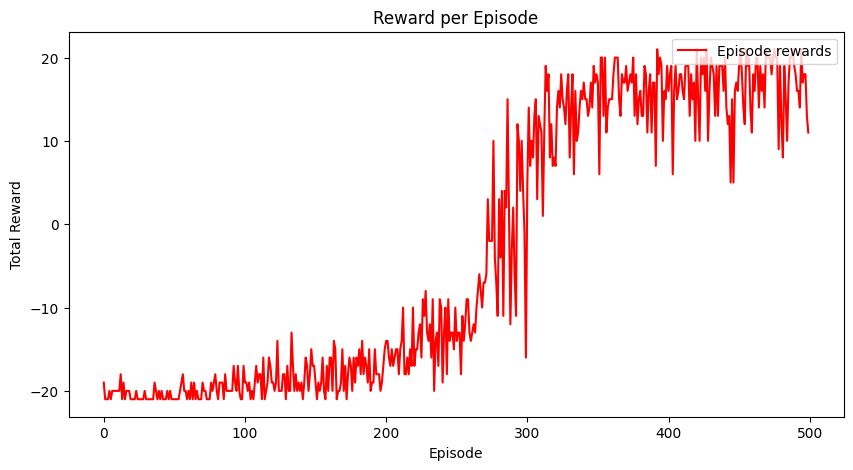

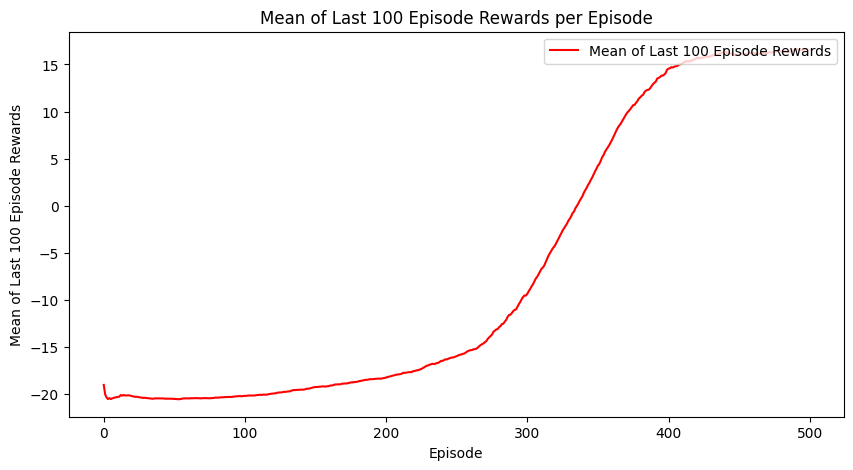

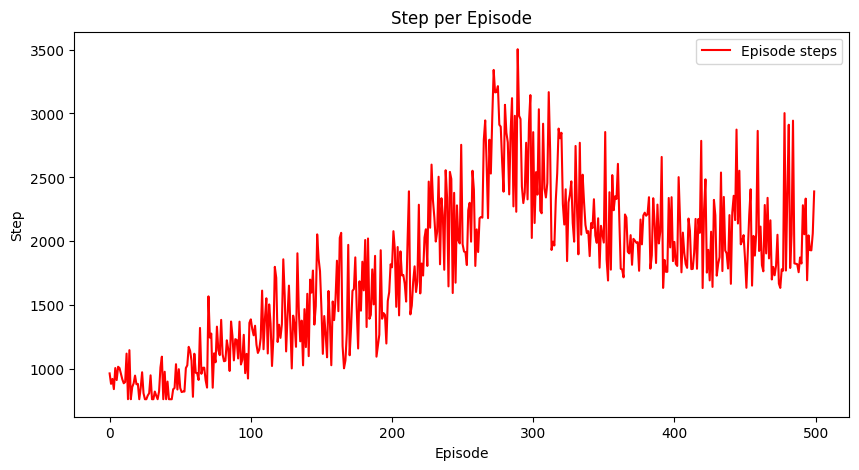

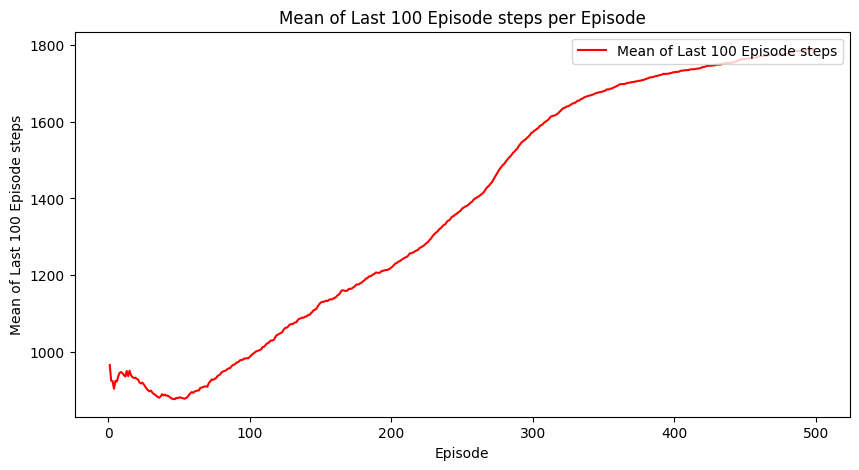

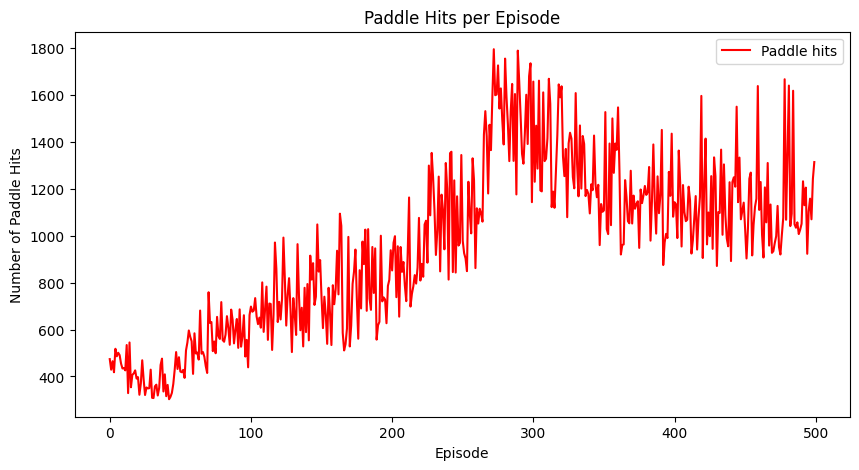

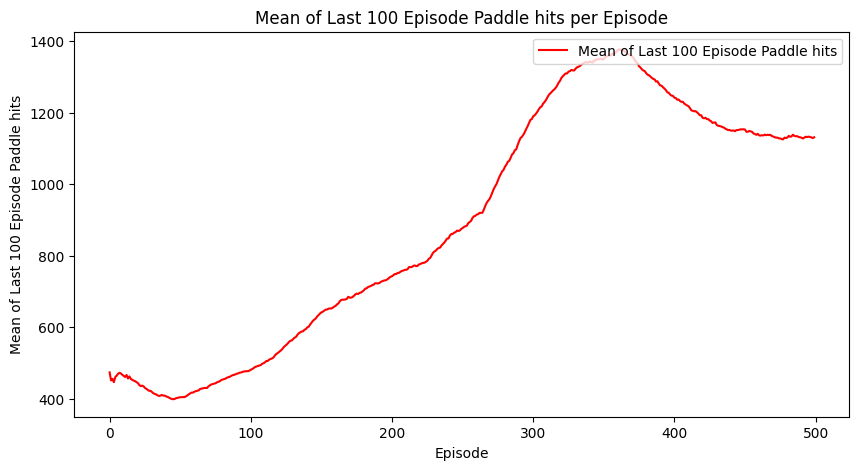

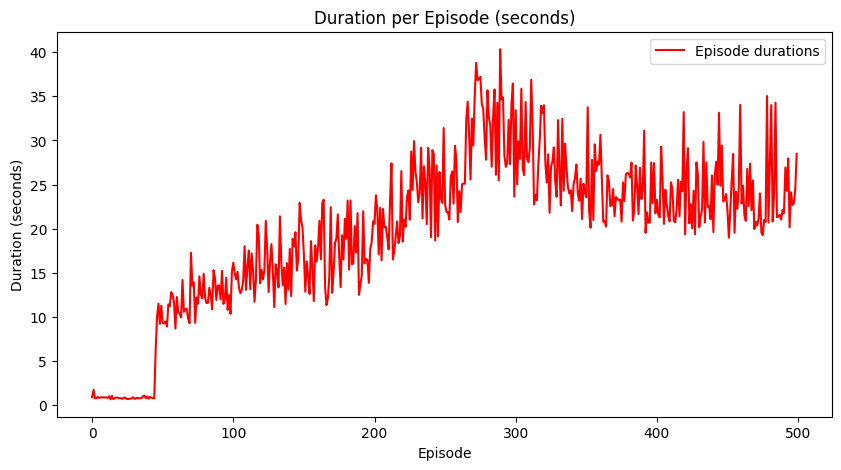

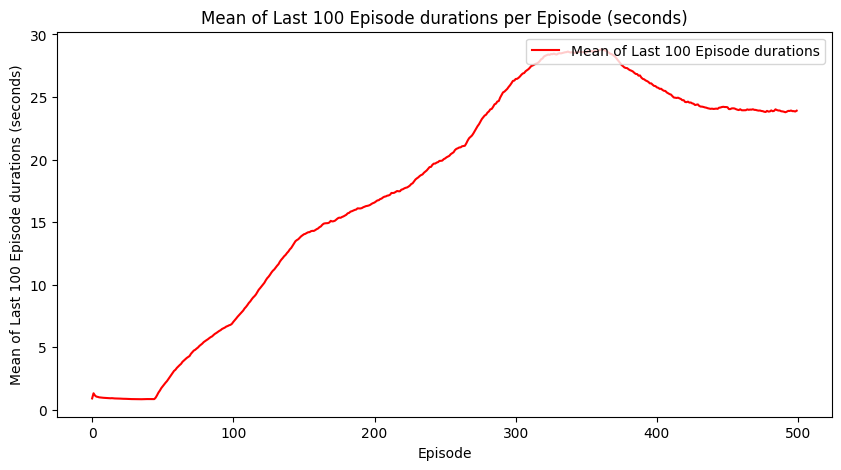

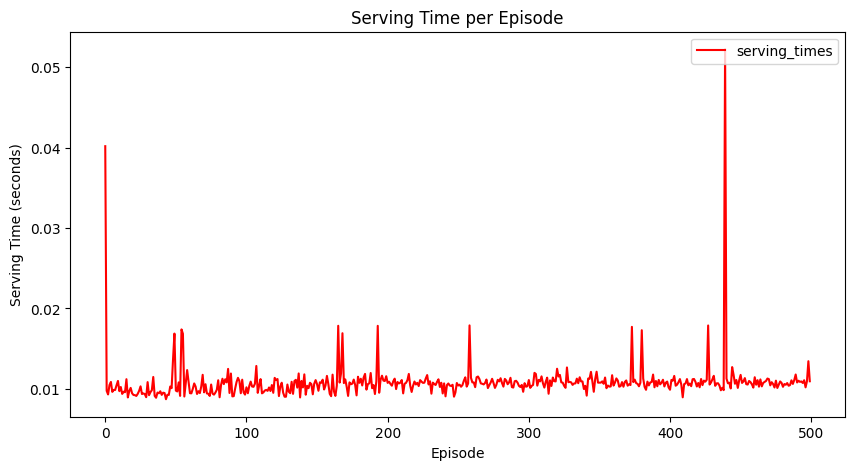

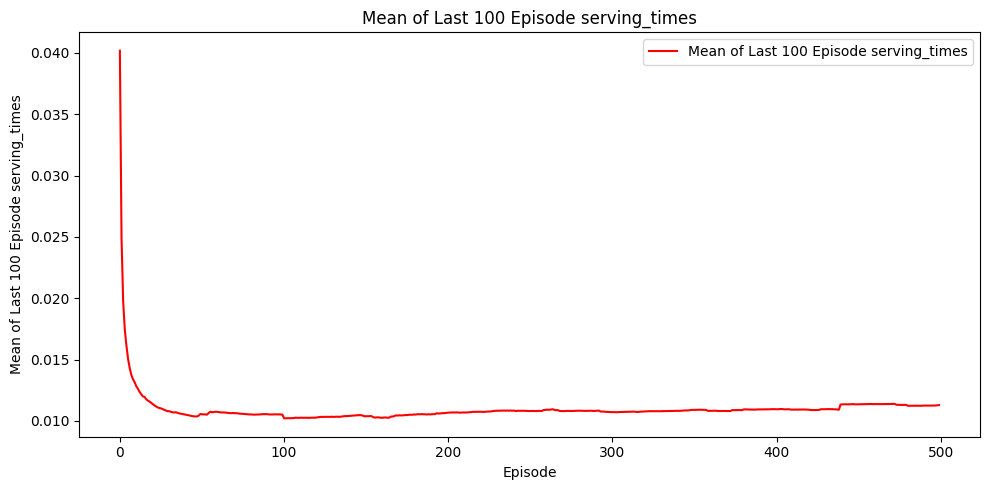

In [7]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(12, 12))

plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label = 'Episode rewards', c='r')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend(loc="upper right")
plt.savefig('Reward per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_reward, label = 'Mean of Last 100 Episode Rewards', c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Rewards')
plt.title('Mean of Last 100 Episode Rewards per Episode')
plt.legend(loc="upper right")
plt.savefig('Mean of Last 100 Episode Rewards per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_steps, label = 'Episode steps', c='r')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.title('Step per Episode')
plt.legend(loc="upper right")
plt.savefig('Step per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_steps, label = 'Mean of Last 100 Episode steps', c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode steps')
plt.title('Mean of Last 100 Episode steps per Episode')
plt.legend(loc="upper right")
plt.savefig('Mean of Last 100 Episode steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(paddle_hits, label ='Paddle hits', c='r')
plt.xlabel('Episode')
plt.ylabel('Number of Paddle Hits')
plt.title('Paddle Hits per Episode')
plt.legend(loc="upper right")
plt.savefig('Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_paddle_hits, label ='Mean of Last 100 Episode Paddle hits', c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Paddle hits')
plt.title('Mean of Last 100 Episode Paddle hits per Episode')
plt.legend(loc="upper right")
plt.savefig('Mean of Last 100 Episode Paddle hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_durations, label = 'Episode durations', c='r')
plt.xlabel('Episode')
plt.ylabel('Duration (seconds)')
plt.title('Duration per Episode (seconds)')
plt.legend(loc="upper right")
plt.savefig('Duration per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_durations, label = 'Mean of Last 100 Episode durations', c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode durations (seconds)')
plt.title('Mean of Last 100 Episode durations per Episode (seconds)')
plt.legend(loc="upper right")
plt.savefig('Mean of Last 100 Episode durations.png')

plt.figure(figsize=(10,5))
plt.plot(serving_times, label ='serving_times', c='r')
plt.xlabel('Episode')
plt.ylabel('Serving Time (seconds)')
plt.title('Serving Time per Episode')
plt.legend(loc="upper right")
plt.savefig('Serving Time per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_serving_times, label ='Mean of Last 100 Episode serving_times', c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode serving_times')
plt.title('Mean of Last 100 Episode serving_times')
plt.legend(loc="upper right")
plt.savefig('Mean of Last 100 Episode serving_times.png')

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
df = pd.DataFrame(list(zip(episode_rewards,mean_last_100_ep_reward, episode_steps, mean_last_100_ep_steps, paddle_hits,mean_last_100_paddle_hits, episode_durations, mean_last_100_ep_durations, serving_times, mean_last_100_serving_times)),
               columns =['episode_rewards', 'mean_last_100_ep_reward', 'episode_steps', 'mean_last_100_ep_steps', 'paddle_hits','mean_last_100_paddle_hits','episode_durations','mean_last_100_ep_durations', 'serving_times', 'mean_last_100_serving_times'])
df.to_csv('/content/gdrive/MyDrive/First_Method.csv')
df

,episode_rewards,mean_last_100_ep_reward,episode_steps,mean_last_100_ep_steps,paddle_hits,mean_last_100_paddle_hits,episode_durations,mean_last_100_ep_durations,serving_times,mean_last_100_serving_times
0,-19.0,-19.000000,966,NaN,474,474.00,0.917404,0.917404,0.040172,0.040172
1,-21.0,-20.000000,884,966.000000,429,451.50,1.742318,1.329861,0.009763,0.024967
2,-21.0,-20.333333,923,925.000000,465,456.00,0.801118,1.153613,0.009311,0.019749
3,-21.0,-20.500000,843,924.333333,418,446.50,0.798033,1.064718,0.010478,0.017431
4,-20.0,-20.400000,1008,904.000000,518,460.80,0.944087,1.040592,0.010866,0.016118
...,...,...,...,...,...,...,...,...,...,...
495,17.0,16.520000,2046,1787.050505,1104,1132.71,24.134905,23.919365,0.011077,0.011247
496,18.0,16.600000,1931,1787.572581,1158,1131.57,22.694825,23.871247,0.010192,0.011246
497,18.0,16.620000,1929,1787.861167,1070,1130.57,22.863862,23.870987,0.010975,0.011248
498,13.0,16.600000,2062,1788.144578,1242,1128.64,24.450708,23.841199,0.013443,0.011273


In [9]:
#Import data from the second method Pandas Dataframe
plot_data=pd.read_csv('/content/gdrive/MyDrive/Second_Method.csv')
Second_Method_episode_rewards=plot_data['episode_rewards'].to_list()
Second_Method_mean_last_100_ep_reward=plot_data['mean_last_100_ep_reward'].to_list()
Second_Method_episode_steps=plot_data['episode_steps'].to_list()
Second_Method_mean_last_100_ep_steps=plot_data['mean_last_100_ep_steps'].to_list()
Second_Method_paddle_hits=plot_data['paddle_hits'].to_list()
Second_Method_mean_last_100_paddle_hits=plot_data['mean_last_100_paddle_hits'].to_list()
Second_Method_episode_durations=plot_data['episode_durations'].to_list()
Second_Method_mean_last_100_ep_durations=plot_data['mean_last_100_ep_durations'].to_list()
Second_Method_serving_times=plot_data['serving_times'].to_list()
Second_Method_mean_last_100_serving_times=plot_data['mean_last_100_serving_times'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


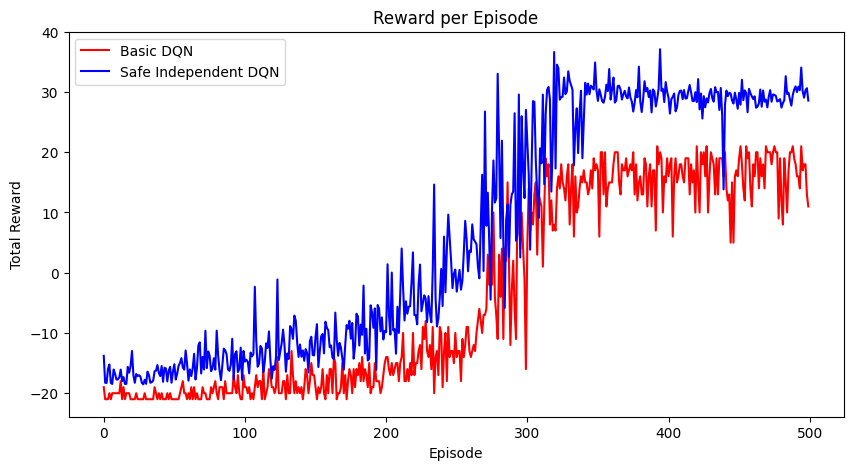

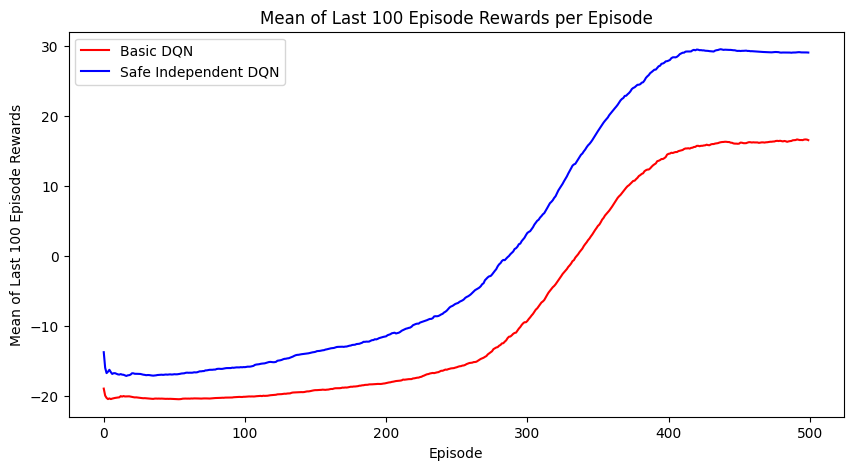

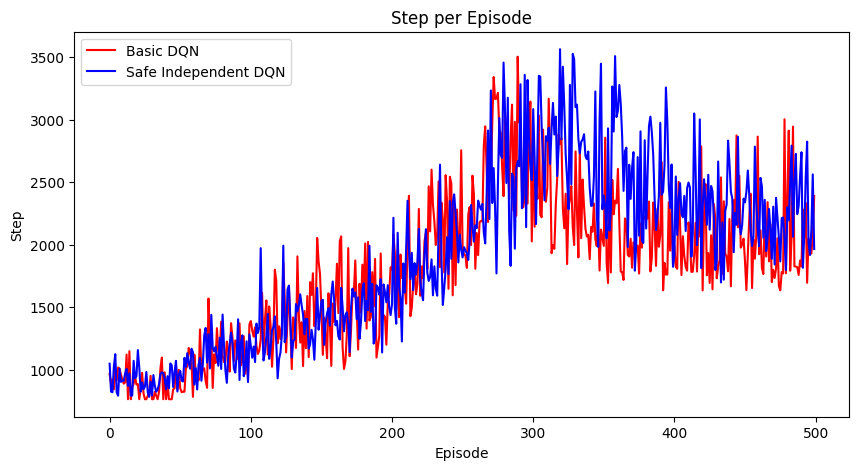

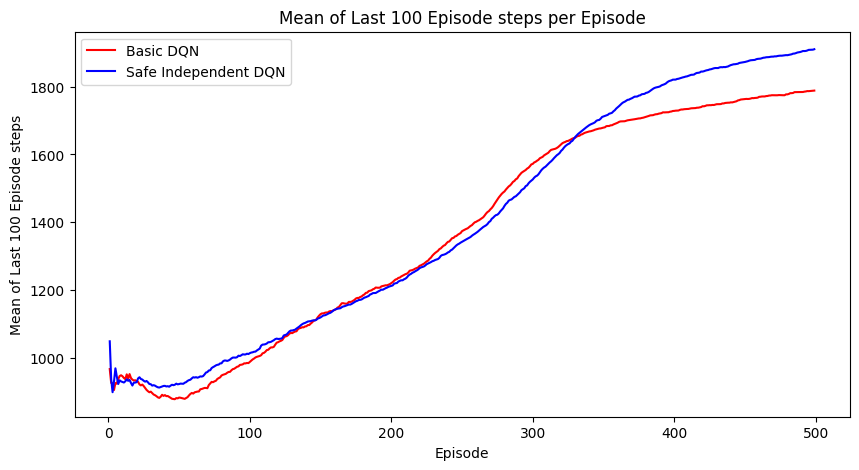

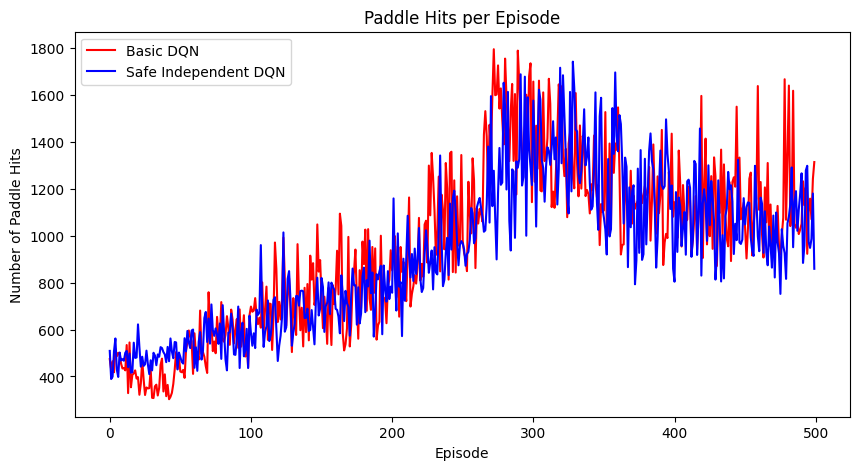

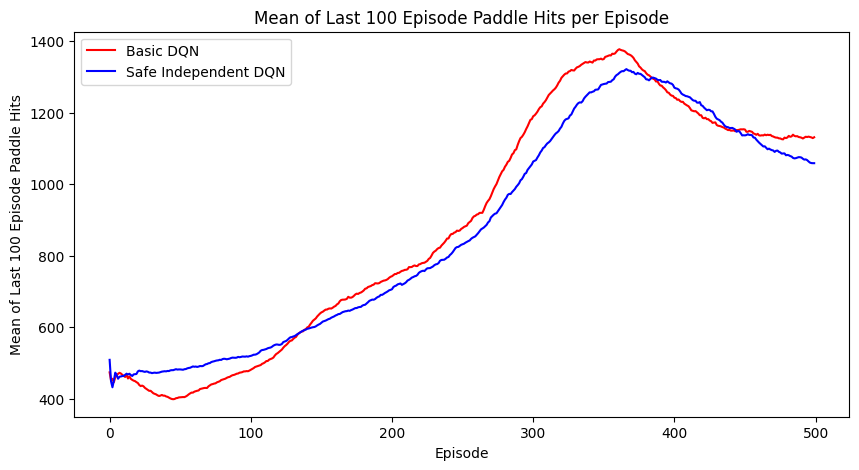

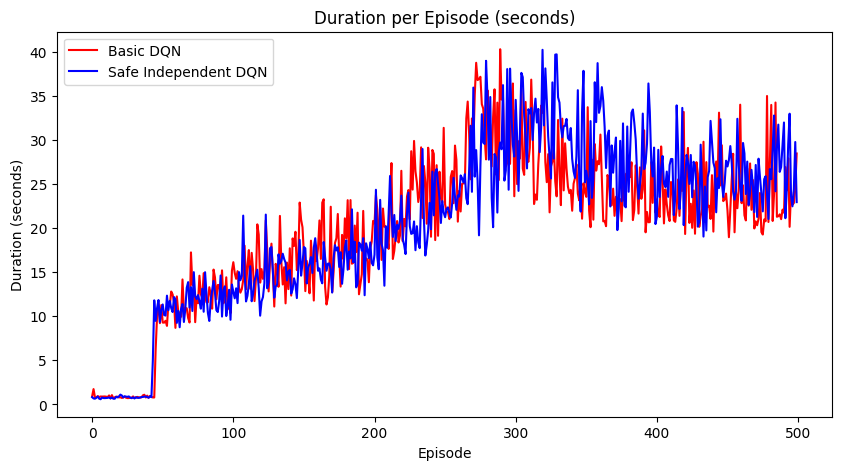

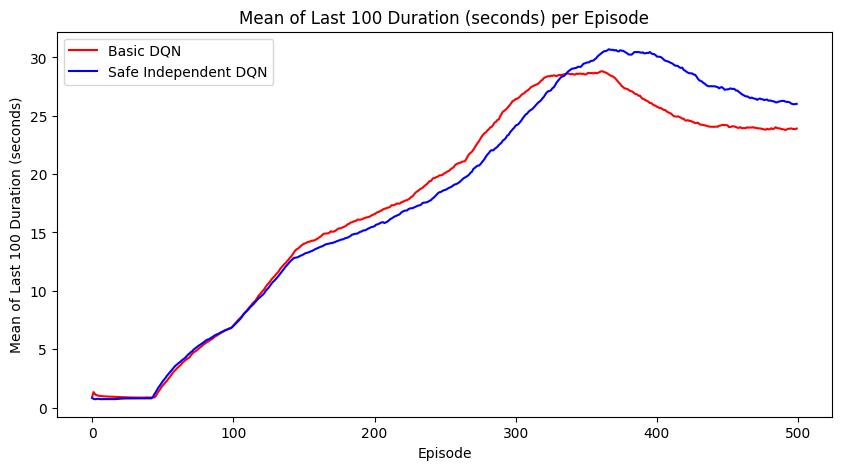

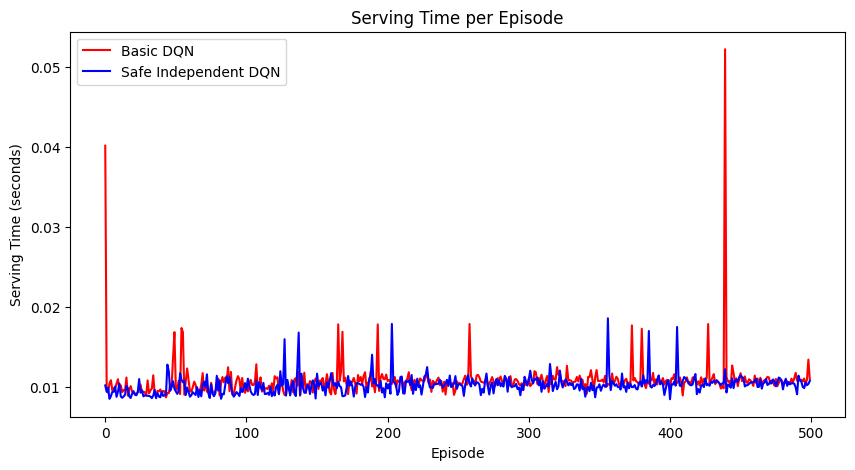

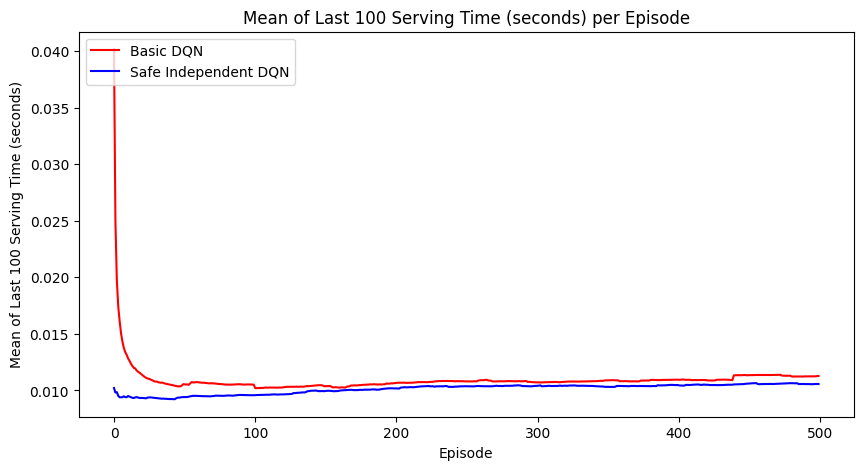

In [10]:
# Plotting comparison
plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label = "Basic DQN" , c='r')
plt.plot(Second_Method_episode_rewards, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Reward per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_reward, label = 'Basic DQN', c='r')
plt.plot(Second_Method_mean_last_100_ep_reward, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Rewards')
plt.title('Mean of Last 100 Episode Rewards per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Rewards per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_steps, label = "Basic DQN", c='r')
plt.plot(Second_Method_episode_steps, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.title('Step per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_steps, label = 'Basic DQN', c='r')
plt.plot(Second_Method_mean_last_100_ep_steps, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode steps')
plt.title('Mean of Last 100 Episode steps per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(paddle_hits, label = "Basic DQN", c='r')
plt.plot(Second_Method_paddle_hits, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Number of Paddle Hits')
plt.title('Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_paddle_hits, label = 'Basic DQN', c='r')
plt.plot(Second_Method_mean_last_100_paddle_hits, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Paddle Hits')
plt.title('Mean of Last 100 Episode Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_durations, label = "Basic DQN", c='r')
plt.plot(Second_Method_episode_durations, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Duration (seconds)')
plt.title('Duration per Episode (seconds)')
plt.legend(loc="upper left")
plt.savefig('Comparison Duration per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_durations, label = 'Basic DQN', c='r')
plt.plot(Second_Method_mean_last_100_ep_durations, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Duration (seconds)')
plt.title('Mean of Last 100 Duration (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Duration (seconds) per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(serving_times, label = "Basic DQN", c='r')
plt.plot(Second_Method_serving_times, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Serving Time (seconds)')
plt.title('Serving Time per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Serving time per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_serving_times, label = "Basic DQN", c='r')
plt.plot(Second_Method_mean_last_100_serving_times, label = "Safe Independent DQN", c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Serving Time (seconds)')
plt.title('Mean of Last 100 Serving Time (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Serving Time (seconds) per Episode.png')

In [11]:
#Statistics

# Calculate mean and median and st dev
mean_reward = np.mean(episode_rewards)
median_reward = np.median(episode_rewards)
std_dev_reward = np.std(episode_rewards)

mean_duration = np.mean(episode_durations)
median_duration = np.median(episode_durations)
std_dev_duration = np.std(episode_durations)

mean_paddle_hits = np.mean(paddle_hits)
median_paddle_hits = np.median(paddle_hits)
std_dev_paddle_hits = np.std(paddle_hits)

mean_episode_steps = np.mean(episode_steps)
median_episode_steps = np.median(episode_steps)
std_dev_episode_steps = np.std(episode_steps)

mean_serving_time = np.mean(serving_times)
median_serving_time = np.median(serving_times)
std_dev_serving_time = np.std(serving_times)

# Print mean, median, and standard deviation values
print("Mean Reward:", mean_duration)
print("Median Reward:", median_duration)
print("Standard Deviation Reward:", std_dev_duration)

print("Mean Duration:", mean_duration)
print("Median Duration:", median_duration)
print("Standard Deviation Duration:", std_dev_duration)

print("Mean Paddle Hits:", mean_paddle_hits)
print("Median Paddle Hits:", median_paddle_hits)
print("Standard Deviation Paddle Hits:", std_dev_paddle_hits)

print("Mean Episode Steps:", mean_episode_steps)
print("Median Episode Steps:", median_episode_steps)
print("Standard Deviation Episode Steps:", std_dev_episode_steps)

print("Mean Serving Time:", mean_serving_time)
print("Median Serving Time:", median_serving_time)
print("Standard Deviation Serving Time:", std_dev_serving_time)

Mean Reward: 19.899519114017487
Median Reward: 21.118183970451355
Standard Deviation Reward: 8.683506095032401
Mean Duration: 19.899519114017487
Median Duration: 21.118183970451355
Standard Deviation Duration: 8.683506095032401
Mean Paddle Hits: 955.876
Median Paddle Hits: 973.0
Standard Deviation Paddle Hits: 354.6048739428154
Mean Episode Steps: 1789.896
Median Episode Steps: 1820.0
Standard Deviation Episode Steps: 596.7704024028002
Mean Serving Time: 0.010822306632995606
Median Serving Time: 0.010642766952514648
Standard Deviation Serving Time: 0.002582750982334381
